 #### <p style="background-color: #EDE7F6;color:#6600ff;display: inline-block;padding:.6rem;border-radius:.5rem">Import libraries</p>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
# Importing some linear models for capturing trend
from sklearn.linear_model import LinearRegression
# Importing some non-linear model for capturing complex patterns
from xgboost import XGBRegressor
# Importing evaluation matrix
from math import sqrt
from sklearn.metrics import mean_squared_log_error
# Importing from statsmodels  -TREND
import statsmodels.api as sm
from statsmodels.tsa.seasonal import MSTL
from statsmodels.tsa.tsatools import lagmat
from statsmodels.tsa.deterministic import DeterministicProcess, CalendarFourier

 #### <p style="background-color: #EDE7F6;color:#6600ff;display: inline-block;padding:.6rem;border-radius:.5rem">Settings</p>

In [3]:
# Making some setting or pandas to show 100 rows
pd.set_option('display.max_rows', 100)

# The %matplotlib inline enables “inline plotting”, where plotted graphics appear in your notebook
# Polecenie to, umieszczone na początku kodu, umożliwia bezpośrednie wyświetlanie wykresu pod komórkami kodu, zwiększając czytelność i wspierając wydajne prototypowanie.
%matplotlib inline

# Setting rcParams
plt.rc(
    'figure',
    autolayout=True,
    figsize=(11,4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    'axes',
    labelweight='bold',
    labelsize='large',
    titlesize=16,
    titlepad=10,
)

# On higher resolution (większe okno)
%config InlineBackend.figure_format = 'retina'

 #### <p style="background-color: #EDE7F6;color:#6600ff;display: inline-block;padding:.6rem;border-radius:.5rem">Import data files</p>

In [4]:
store_sales = pd.read_csv("train.csv",
    index_col='id', parse_dates=['date'],
     dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
        'onpromotion': 'uint32',
                     })
oil_prices = pd.read_csv("oil.csv", parse_dates=['date'])
holidays = pd.read_csv('holidays_events.csv', parse_dates=['date'])
test = pd.read_csv('test.csv', parse_dates=['date'],
                    dtype={
                    'store_nbr': 'category',
                   'family': 'category',
                   'onpromotion': 'uint32',
                  })

### <p style="background-color: #EDE7F6; color: #6600ff;margin:0; display:inline-block;padding:.6rem;border-radius:.25rem;">I.DATA PREPARATION</p>

In [5]:
holidays.tail(3)

,date,type,locale,locale_name,description,transferred
347,2017-12-24,Additional,National,Ecuador,Navidad-1,False
348,2017-12-25,Holiday,National,Ecuador,Navidad,False
349,2017-12-26,Additional,National,Ecuador,Navidad+1,False


In [6]:
store_sales_s = store_sales.groupby(['date'])[['sales','onpromotion']].mean()

In [7]:
store_sales_s = store_sales_s.reset_index()

In [8]:
# Droppring holidays havig Transferred = True as they were normal days because there event was transferred to some other date
holidays = holidays[holidays['date'] >= '2013-01-01']
# Taking only date and description of the holiday
holidays = holidays[['date','locale', 'description','transferred']]

In [9]:
holidays.tail(3)

,date,locale,description,transferred
347,2017-12-24,National,Navidad-1,False
348,2017-12-25,National,Navidad,False
349,2017-12-26,National,Navidad+1,False


#### <p style="background-color: #EDE7F6; color: #6600ff;margin:0; display:inline-block;padding:.6rem;border-radius:.25rem;">Sales and Oil prices</p>

In [10]:
# Now we will merge the store_sales_s dataset with the oil_prices dataset
store_sales_O = store_sales_s.merge(oil_prices, on='date', how='left')
store_sales_O.isna().sum()

date             0
sales            0
onpromotion      0
dcoilwtico     521
dtype: int64

In [11]:
# fill null oil price values with interpolate method, and all others back/forward fill
num = [x for x in store_sales_O.columns if store_sales_O.dtypes[x] in ['float64']]

In [12]:
for i in num:
    store_sales_O[i] = store_sales_O[i].fillna(store_sales_O[i].bfill())

In [13]:
# store_sales_O.dcoilwtico.fillna(method='ffill', inplace=True)
# store_sales_O.dcoilwtico.fillna(method='bfill', inplace=True)
# print(store_sales_O.isna().sum())

In [13]:
store_sales_O.isna().sum()

date           0
sales          0
onpromotion    0
dcoilwtico     0
dtype: int64

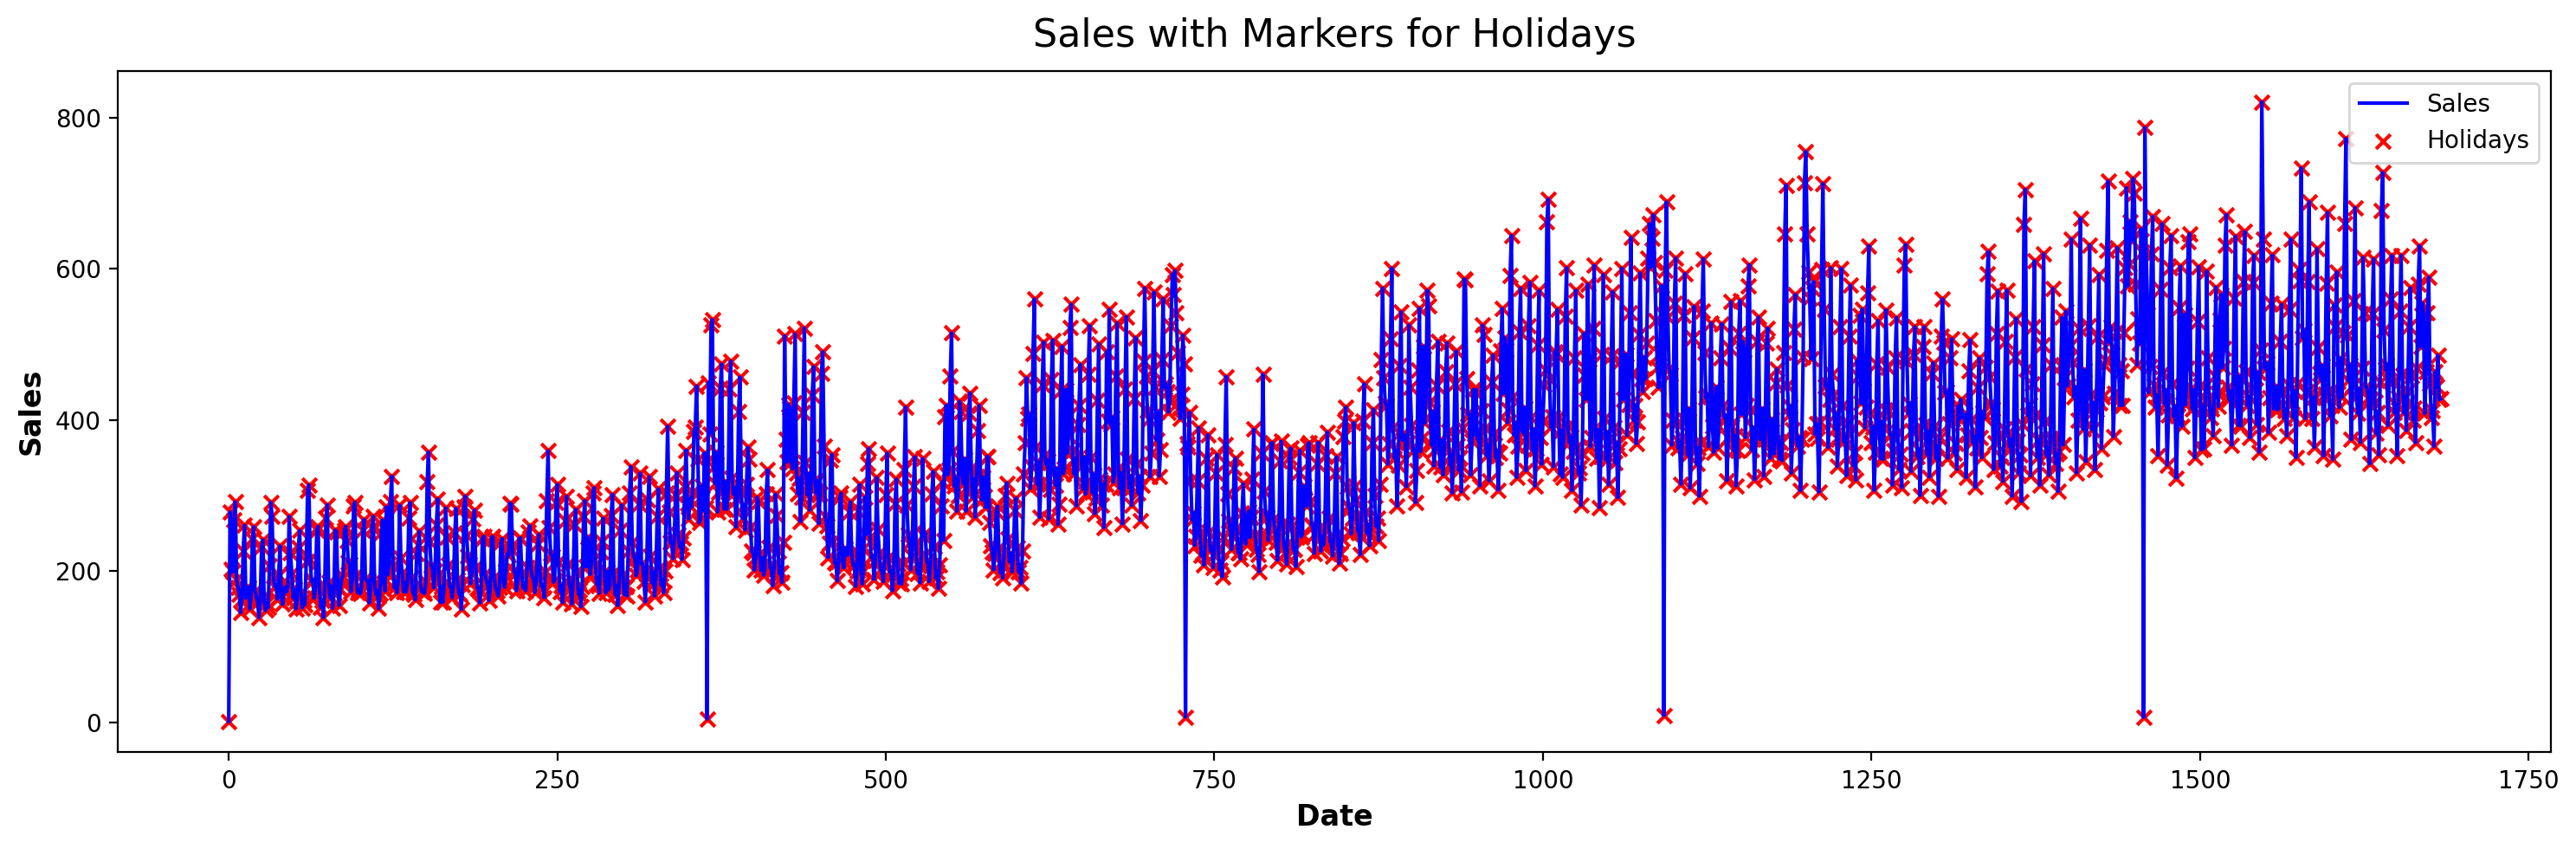

In [16]:
plt.figure(figsize=(15, 5))
plt.plot(store_sales_O['sales'], linestyle='-', color='blue', label='Sales')


# holidays_2 = holidays[holidays['description'].notna()]
plt.scatter(store_sales_O.index, store_sales_O['sales'], color='red', marker='x', label='Holidays')

# Customize the plot
plt.title('Sales with Markers for Holidays')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

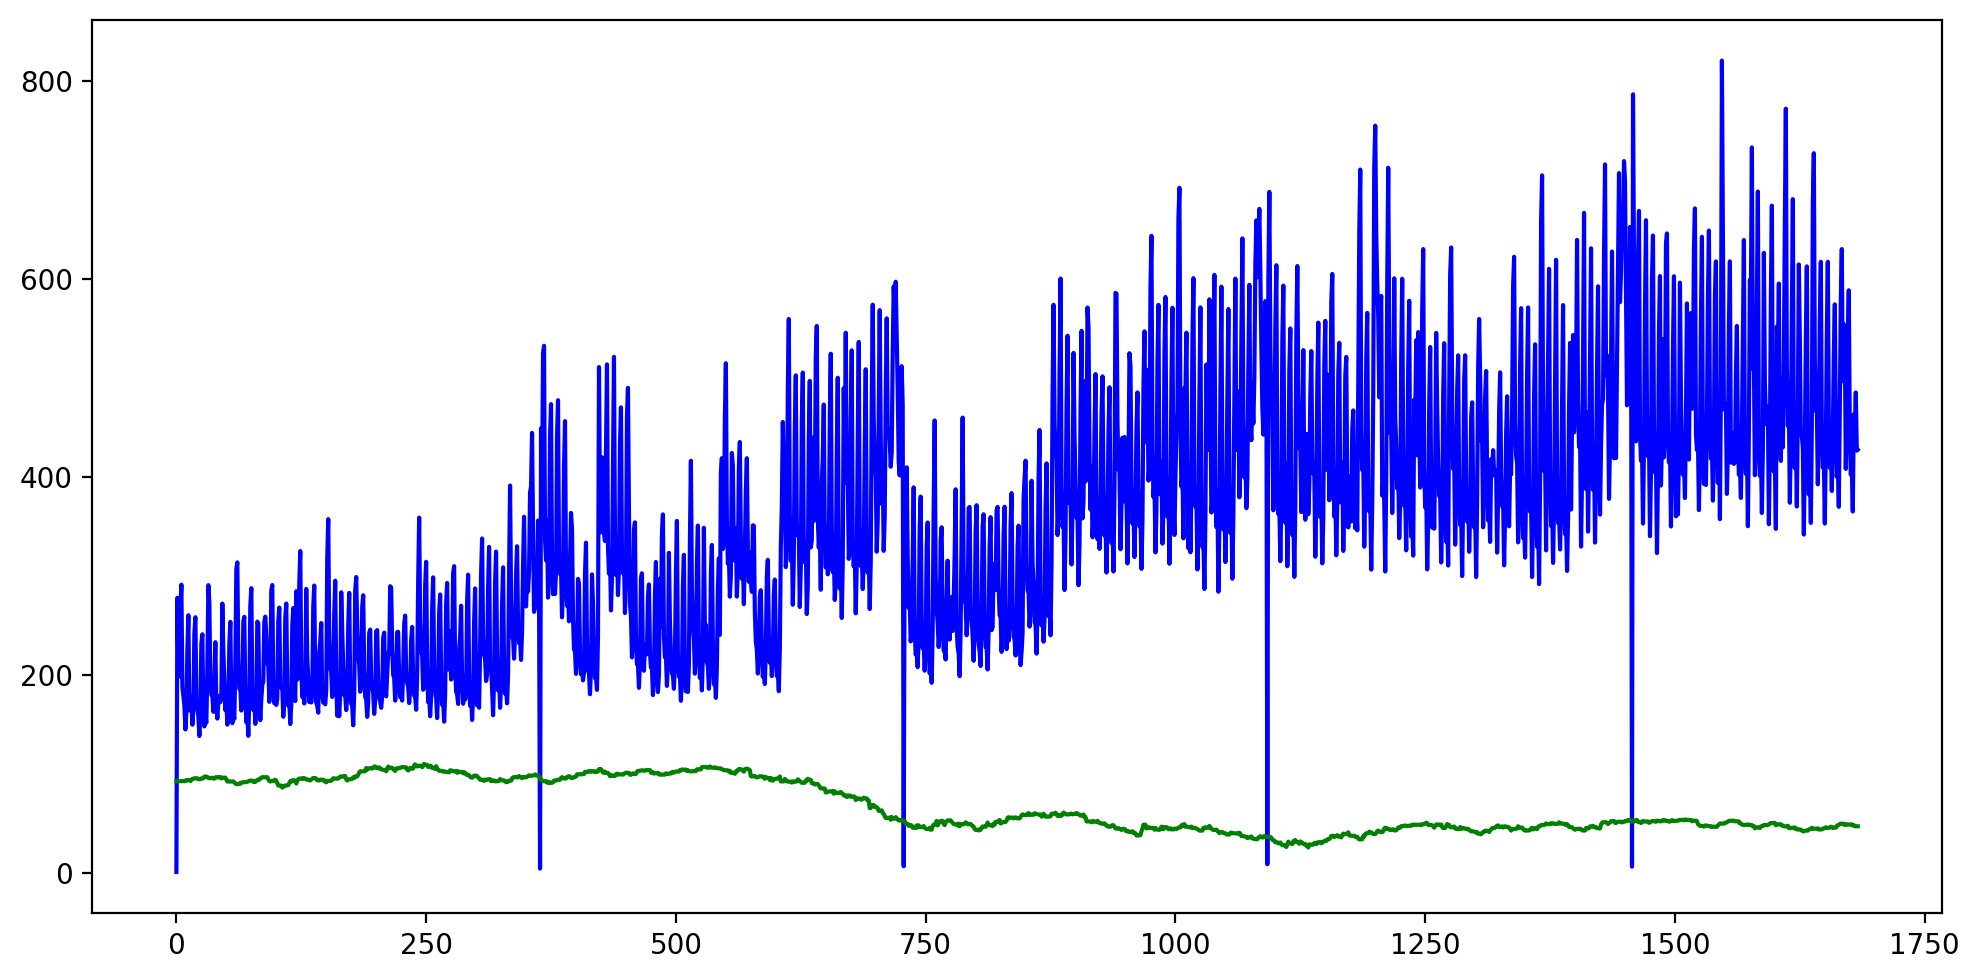

In [17]:
plt.figure(figsize=(10, 5))
plt.plot(store_sales_O['sales'], linestyle='-', color='blue', label='Sales')
plt.plot(store_sales_O['dcoilwtico'], linestyle='-', color='green', label='Oil Price')

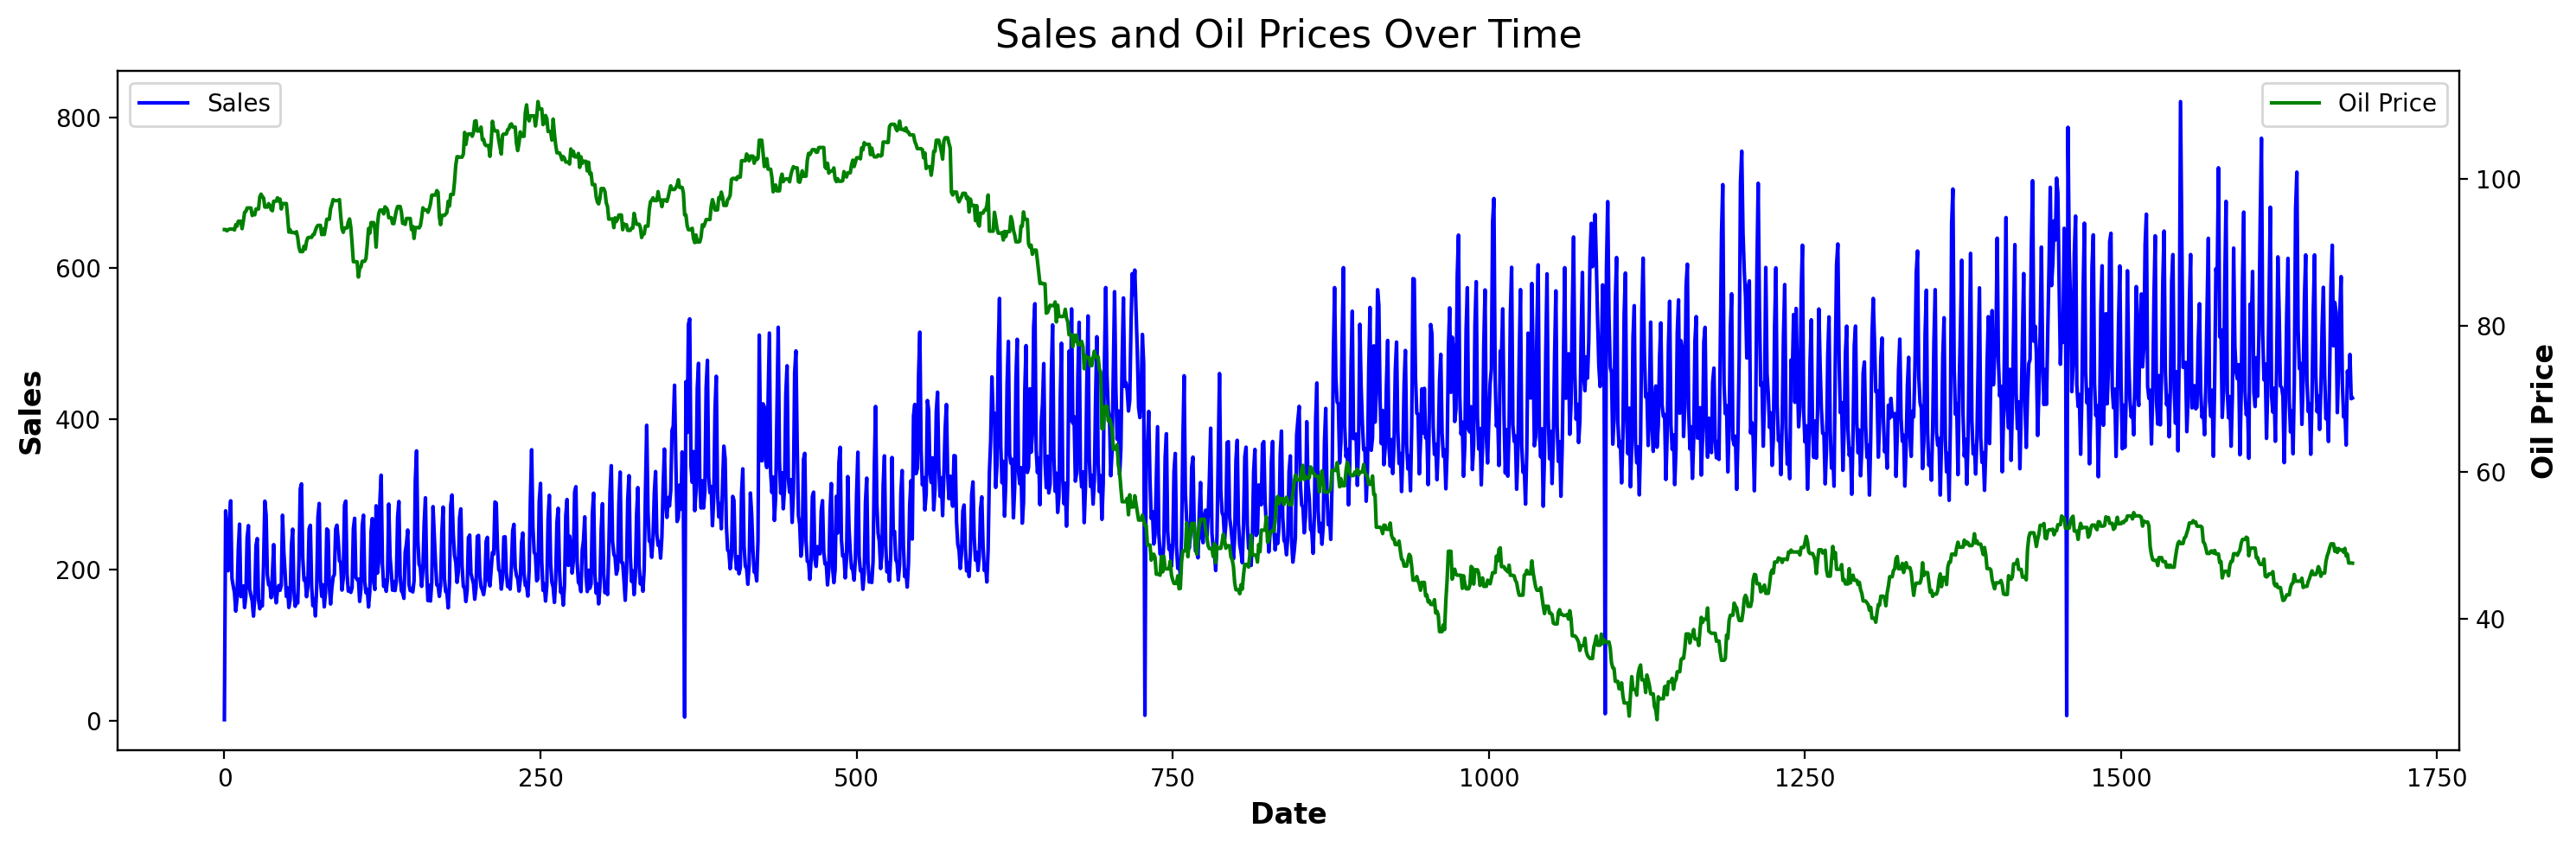

In [18]:
# Plotting using pandas.plot()
# fig, ax1 = plt.subplots(figsize=(15, 5))

# Plot 'sales' on the first y-axis (ax1)
ax1 = store_sales_O['sales'].plot(figsize=(15, 5), color='blue', label='Sales')
ax1.set_ylabel('Sales')
ax1.set_xlabel('Date')

# Creating a secondary y-axis for 'dcoilwtico' (oil prices)
ax2 = ax1.twinx()
store_sales_O['dcoilwtico'].plot(color='green', label='Oil Price')
ax2.set_ylabel('Oil Price')

# Displaying the legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.title('Sales and Oil Prices Over Time')
plt.show()


<Axes: xlabel='dcoilwtico', ylabel='sales'>

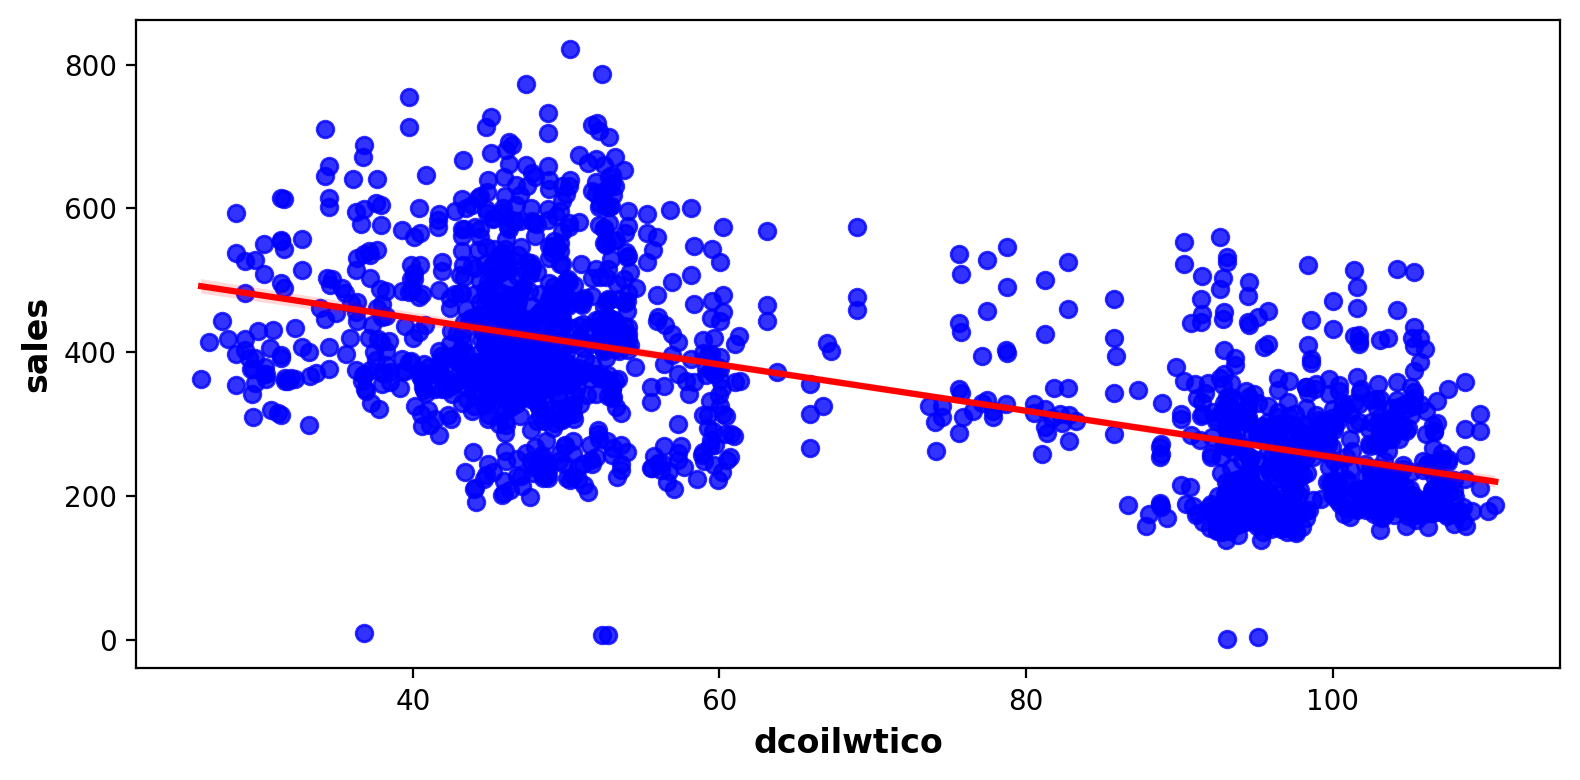

In [18]:
# Plotting the regression plot between sales and oil price
plt.figure(figsize=(8, 4))
sns.regplot(data=store_sales_O, x='dcoilwtico', y='sales',color='blue', line_kws={'color': 'red'})

In [19]:
# oil_prices.set_index('date', inplace=True)
# oil_prices

In [20]:
# write a function to create new columns for year, month, day, and day name

def date_features(x):
    x['date'] = pd.to_datetime(x['date'])

    x['year'] = x['date'].dt.year
    x['month'] = x['date'].dt.month
    x['day'] = x['date'].dt.day
    x['day_name'] = x['date'].dt.day_name()
    return x

store_sales_O = date_features(store_sales_O)
store_sales_O.head()

,date,sales,onpromotion,dcoilwtico,year,month,day,day_name
0,2013-01-01,1.409438,0.0,93.14,2013,1,1,Tuesday
1,2013-01-02,278.390808,0.0,93.14,2013,1,2,Wednesday
2,2013-01-03,202.840195,0.0,92.97,2013,1,3,Thursday
3,2013-01-04,198.911163,0.0,93.12,2013,1,4,Friday
4,2013-01-05,267.873260,0.0,93.20,2013,1,5,Saturday


In [21]:
# merge national holidays with merge3 to create df for EDA

merge4 = pd.merge(store_sales_O, holidays, on='date', how='left')
merge4.rename(columns={'description' : 'holiday'}, inplace=True)

df = merge4
df.head()

,date,sales,onpromotion,dcoilwtico,year,month,day,day_name,locale,holiday,transferred
0,2013-01-01,1.409438,0.0,93.14,2013,1,1,Tuesday,National,Primer dia del ano,False
1,2013-01-02,278.390808,0.0,93.14,2013,1,2,Wednesday,NaN,NaN,NaN
2,2013-01-03,202.840195,0.0,92.97,2013,1,3,Thursday,NaN,NaN,NaN
3,2013-01-04,198.911163,0.0,93.12,2013,1,4,Friday,NaN,NaN,NaN
4,2013-01-05,267.873260,0.0,93.20,2013,1,5,Saturday,National,Recupero puente Navidad,False


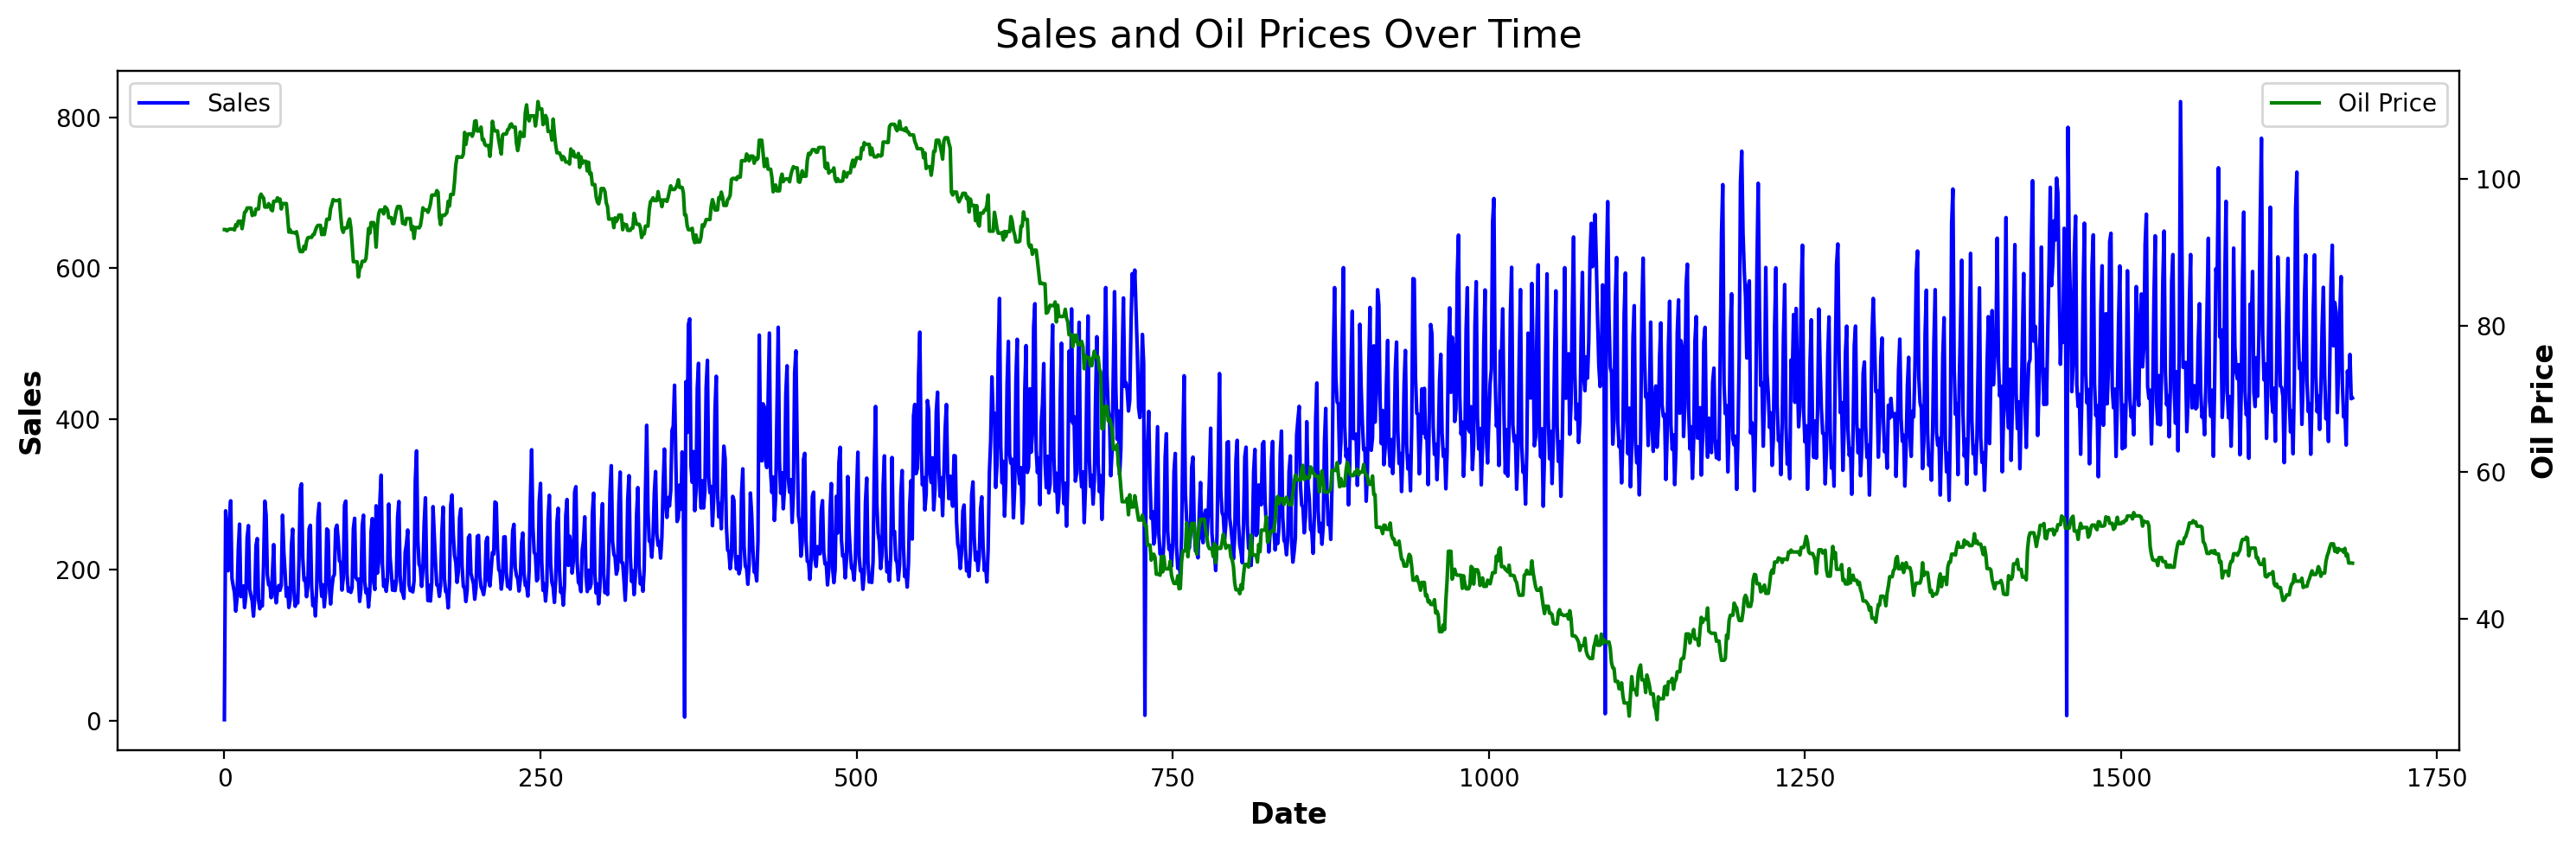

In [22]:
ax1 = store_sales_O['sales'].plot(figsize=(15, 5), color='blue', label='Sales')
ax1.set_ylabel('Sales')
ax1.set_xlabel('Date')

# Creating a secondary y-axis for 'dcoilwtico' (oil prices)
ax2 = ax1.twinx()
store_sales_O['dcoilwtico'].plot(color='green', label='Oil Price')
ax2.set_ylabel('Oil Price')

# Displaying the legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.title('Sales and Oil Prices Over Time')
plt.show()

In [23]:
df.head(3)

,date,sales,onpromotion,dcoilwtico,year,month,day,day_name,locale,holiday,transferred
0,2013-01-01,1.409438,0.0,93.14,2013,1,1,Tuesday,National,Primer dia del ano,False
1,2013-01-02,278.390808,0.0,93.14,2013,1,2,Wednesday,NaN,NaN,NaN
2,2013-01-03,202.840195,0.0,92.97,2013,1,3,Thursday,NaN,NaN,NaN


In [36]:
store_sales_O.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1684 entries, 0 to 1683
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         1684 non-null   datetime64[ns]
 1   sales        1684 non-null   float32       
 2   onpromotion  1684 non-null   float64       
 3   dcoilwtico   1684 non-null   float64       
 4   year         1684 non-null   int32         
 5   month        1684 non-null   int32         
 6   day          1684 non-null   int32         
 7   day_name     1684 non-null   object        
dtypes: datetime64[ns](1), float32(1), float64(2), int32(3), object(1)
memory usage: 79.1+ KB


Text(0.5, 0, 'Date')

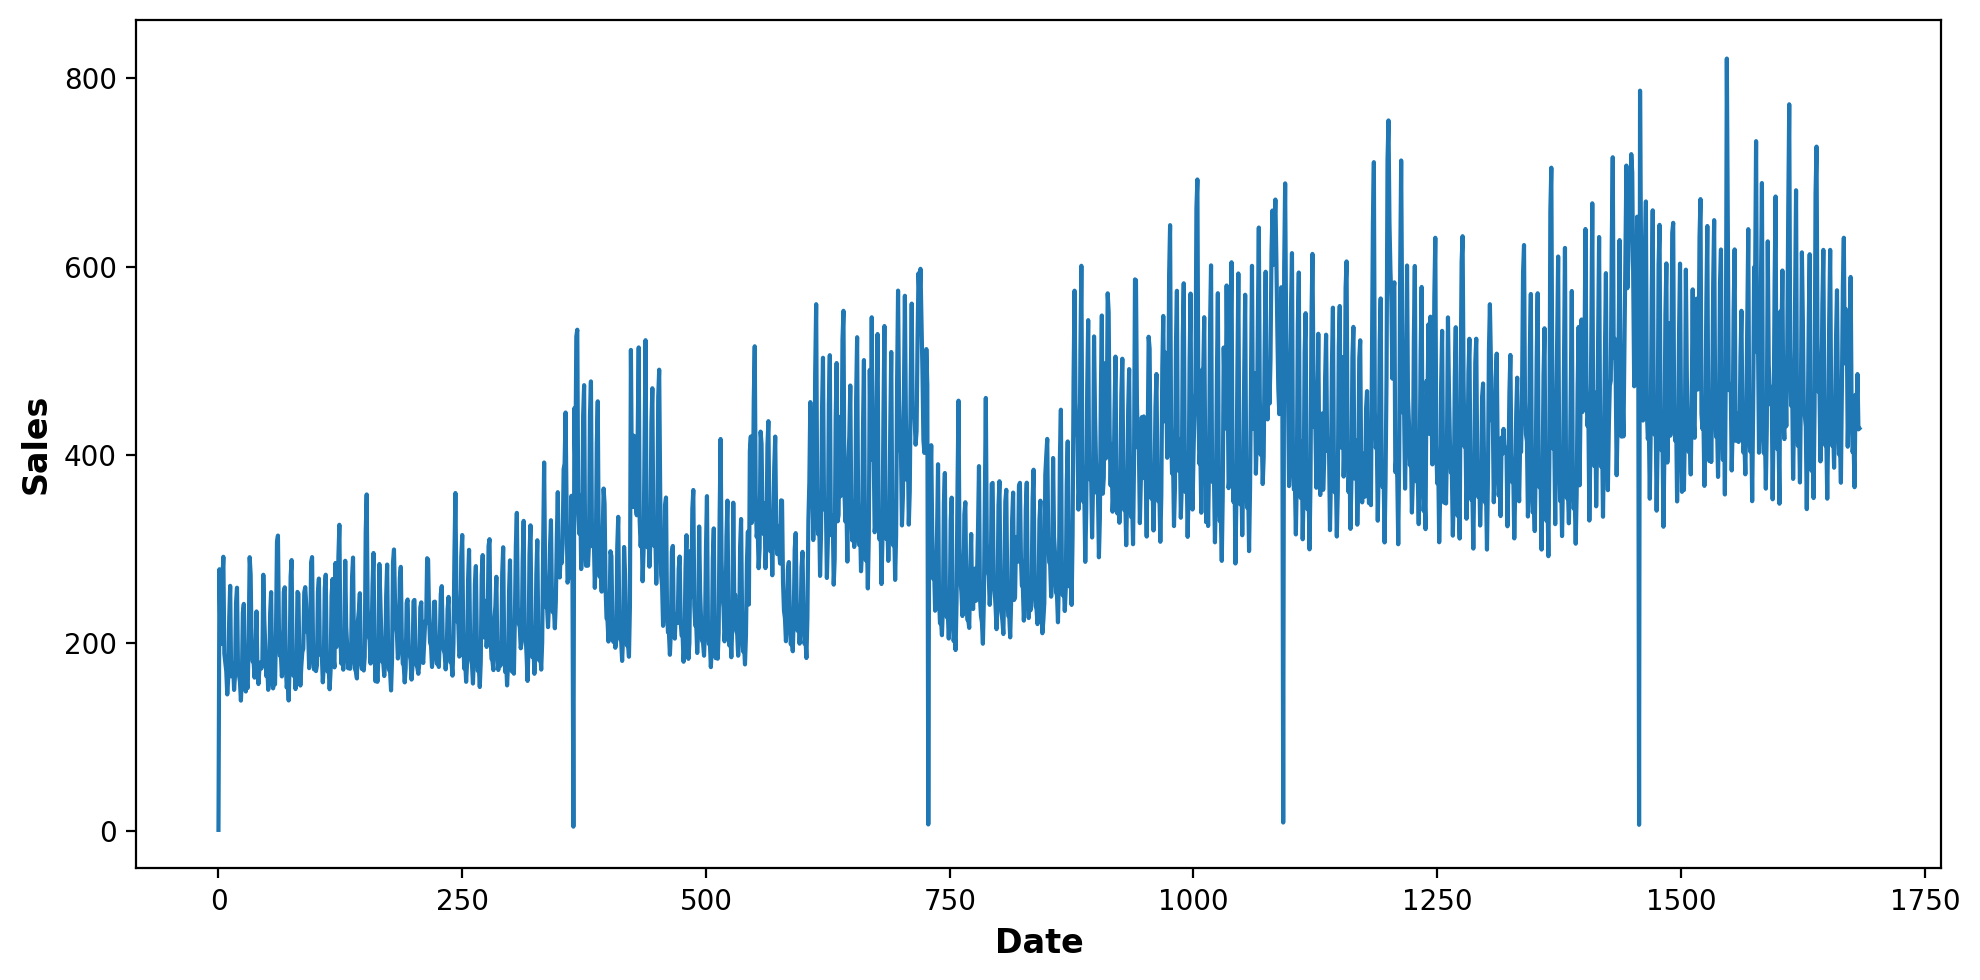

In [24]:
ax4 =  store_sales_O['sales'].plot(figsize=(10, 5), linestyle='-', label='Sales')
ax4.set_ylabel('Sales')
ax4.set_xlabel('Date')
# ax5= ax4.twinx()
# plt.scatter(df.index, df['sales'], color='red', marker='x', label='holidayasdas')


In [27]:
df.tail(3)

,date,sales,onpromotion,dcoilwtico,year,month,day,day_name,locale,holiday,transferred
1711,2017-08-13,485.768616,5.209315,47.59,2017,8,13,Sunday,NaN,NaN,NaN
1712,2017-08-14,427.004730,4.513468,47.59,2017,8,14,Monday,NaN,NaN,NaN
1713,2017-08-15,427.980896,5.951178,47.57,2017,8,15,Tuesday,Local,Fundacion de Riobamba,False


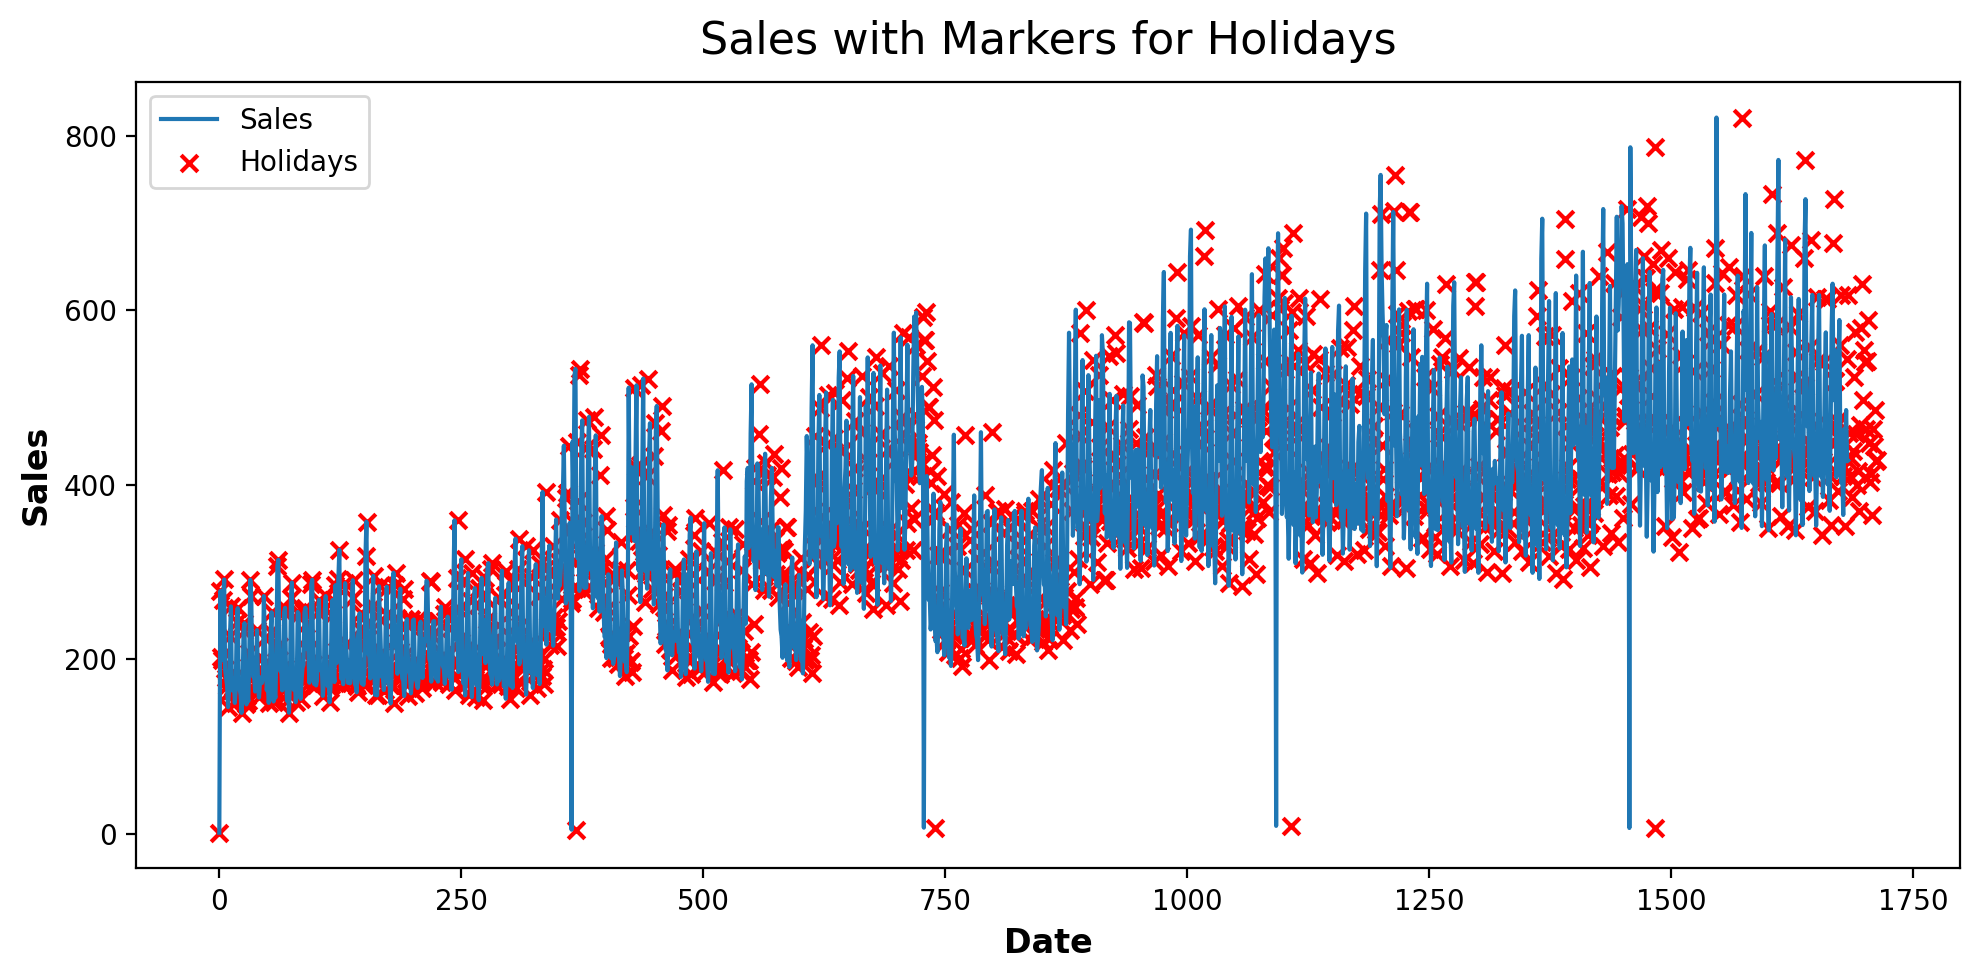

In [26]:
plt.figure(figsize=(10, 5))
plt.plot(store_sales_O['sales'], linestyle='-', label='Sales')


# holidays_2 = holidays[holidays['description'].notna()]
plt.scatter(df.index, df['sales'], color='red', marker='x', label='Holidays')

# Customize the plot
plt.title('Sales with Markers for Holidays')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [136]:
holidays.tail()

,date,locale,description,transferred
345,2017-12-22,National,Navidad-3,False
346,2017-12-23,National,Navidad-2,False
347,2017-12-24,National,Navidad-1,False
348,2017-12-25,National,Navidad,False
349,2017-12-26,National,Navidad+1,False


In [137]:
# drop holidays that were transferred and those that aren't national holidays

holidays = holidays[holidays.transferred != True]
holidays = holidays[holidays.locale == 'National']
holidays = holidays.drop(columns=[ 'locale',  'transferred'])

In [138]:
merge5 = pd.merge(store_sales_O, holidays, on='date', how='left')
merge5.rename(columns={'description' : 'holiday'}, inplace=True)

df2 = merge5
df2.head()

,date,sales,onpromotion,dcoilwtico,year,month,day,day_name,holiday
0,2013-01-01,1.409438,0.0,93.14,2013,1,1,Tuesday,Primer dia del ano
1,2013-01-02,278.390808,0.0,93.14,2013,1,2,Wednesday,NaN
2,2013-01-03,202.840195,0.0,92.97,2013,1,3,Thursday,NaN
3,2013-01-04,198.911163,0.0,93.12,2013,1,4,Friday,NaN
4,2013-01-05,267.873260,0.0,93.20,2013,1,5,Saturday,Recupero puente Navidad


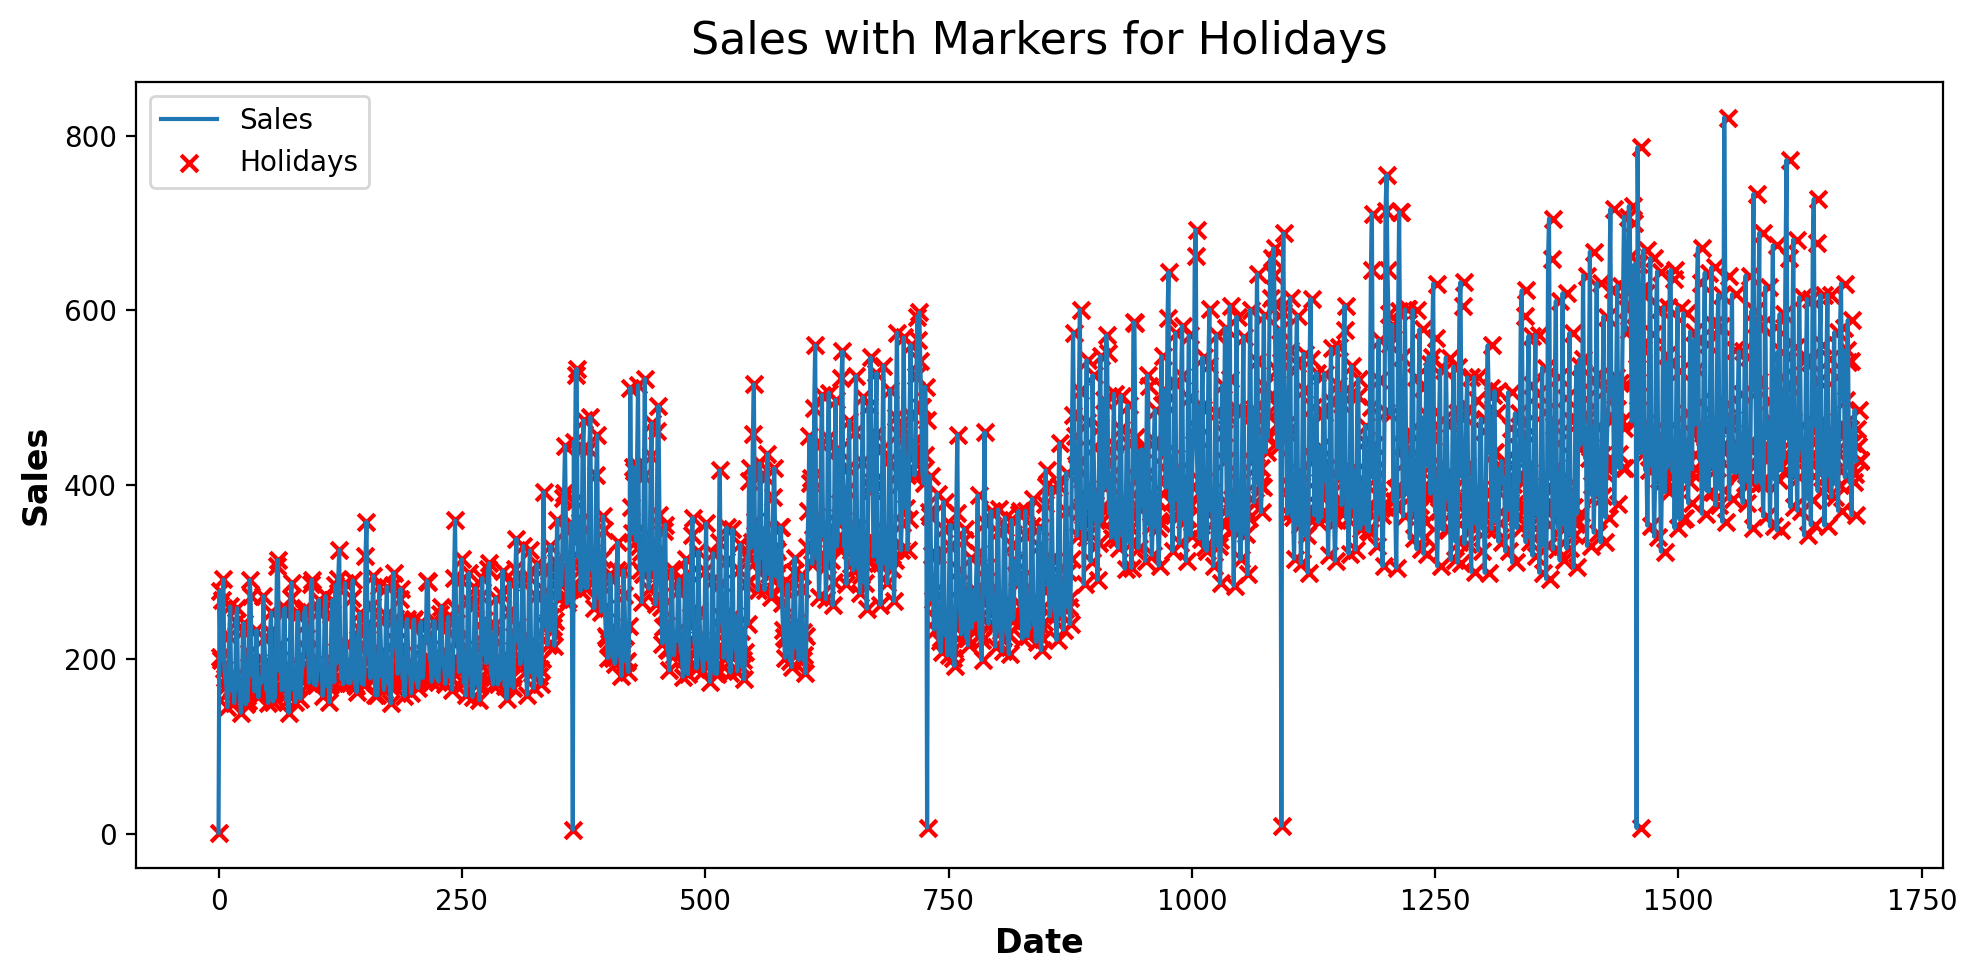

In [139]:
plt.figure(figsize=(10, 5))
plt.plot(store_sales_O['sales'], linestyle='-', label='Sales')


# holidays_2 = holidays[holidays['description'].notna()]
plt.scatter(df2.index, df2['sales'], color='red', marker='x', label='Holidays')

# Customize the plot
plt.title('Sales with Markers for Holidays')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()